### A) Finray Simulation

In [1]:
import mujoco
import mujoco_viewer
import numpy as np
import os
from lxml import etree
import lxml.etree as ET
import time
import uuid
import tempfile

##############################################
# Helper functions for XML attribute swapping
##############################################
def swap_par(tree, element_type, element_name, attribute_name, new_value):
    element = tree.find(f'.//{element_type}[@name="{element_name}"]')
    if element is not None:
        element.set(attribute_name, new_value)

##############################################
# Helper function to add a dynamic site to a body
##############################################
def add_dynamic_site(tree, body_name, site_name, pos):
    body_elem = tree.find(f'.//body[@name="{body_name}"]')
    if body_elem is not None:
        new_site = ET.Element("site", name=site_name, size="0.0001", pos=pos, rgba="1 0 0 1")
        body_elem.append(new_site)
    return site_name

#########################################################
# Function to generate a cantilever beam XML segment string
#########################################################
def generate_xml(ID, n):
    xml_output = []
    n_closers = n
    if isinstance(ID, str) and ID.startswith("R"):
        xml_output.append('<body>')
        xml_output.append('<joint type="free"/>')
        n_closers += 1
    xml_output.append(f'<body name="ID{ID}_b_0" pos="0 0 0" euler="0 0 0">')
    xml_output.append(f'<site name="ID{ID}_b_0_sroot" size="0.0001" pos="0 0 0"/>')
    xml_output.append(f'<geom name="ID{ID}_b_0_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
    xml_output.append(f'<site name="ID{ID}_b_0_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(1, n + 1):
        xml_output.append(f'<body name="ID{ID}_b_{i}" pos="0 0 0" euler="0 0 0">')
        xml_output.append(f'<joint name="ID{ID}_b_{i}_j" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="0" damping="0.00001"/>')
        xml_output.append(f'<geom name="ID{ID}_b_{i}_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
        xml_output.append(f'<site name="ID{ID}_b_{i}_s" size="0.0001" pos="0 0 0.05"/>')
    xml_output.append(f'<site name="ID{ID}_b_{n+1}_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(n_closers + 1):
        xml_output.append('</body>')
    return '\n'.join(xml_output)

#########################################################
# Function to update geometry and dynamic parameters in XML tree
#########################################################
def reparcer(ID, geom_pars, n, tree):
    L, b, t, alpha_k = geom_pars
    l_i = L / n
    l_0 = l_i / 2
    E = 18.5e6
    I = t**3 * b / 12
    k_i = E * I / l_i
    d_i = k_i * alpha_k
    for i in range(0, n+1):
        if i == 0:
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_0_s', 'pos', f"0 0 {l_0/2}")
        elif i == n:
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {l_i}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
        else:
            pos = l_0 if i == 1 else l_i
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {pos}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_i/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
            swap_par(tree, 'site', f'ID{ID}_b_{n+1}_s', 'pos', f"0 0 {l_0}")

def site_searcher(L, L_site, n):
    li = L / n
    l0 = li / 2
    segments = [l0] + [li] * (n - 1) + [l0]
    cumulative = 0.0
    for idx, seg_length in enumerate(segments):
        if cumulative + seg_length >= L_site:
            local_offset = L_site - cumulative
            return idx, local_offset
        cumulative += seg_length
    return len(segments) - 1, segments[-1]

#########################################################
# Combined function: generate a parameterized Finray model and run simulation
#########################################################
def run_finray_simulation(
    rib_angles_deg,
    thickness_ribs,
    n_springs_front,
    n_springs_back,
    n_springs_rib,
    thickness_front,
    thickness_back,
    beam_width,
    L0,
    X1,
    xf,
    zf,
    moving_cylinder_x,
    moving_cylinder_z,
    moving_cylinder_radius,
    moving_cylinder_displacement,
    vis
):
    alpha_k = 5e-3
    phi_a = np.arctan((L0 - zf) / xf)
    phi_b = -np.arctan(zf / (X1 + xf))
    beta = np.arctan(L0 / X1)
    L1 = np.sqrt(L0**2 + X1**2)

    ribs_geom = {}
    valid_rib_indices = []
    for idx, angle_deg in enumerate(rib_angles_deg):
        phi_r = np.deg2rad(angle_deg)
        if phi_r < phi_b or phi_r > phi_a:
            continue
        L_A = zf + xf * np.tan(phi_r)
        L_B = (X1 * np.tan(phi_r) + L_A) / (np.sin(beta) + np.cos(beta) * np.tan(phi_r))
        P_A_z = L_A
        P_B_x = X1 - L_B * np.sin(0.5 * np.pi - beta)
        P_B_z = L_B * np.cos(0.5 * np.pi - beta)
        L_rib = np.sqrt((0 - P_B_x)**2 + (P_A_z - P_B_z)**2)
        alpha_rib = np.arcsin((P_B_z - P_A_z) / L_rib)
        ribs_geom[idx] = {'L_A': L_A, 'L_B': L_B, 'P_A_z': P_A_z, 'L_rib': L_rib, 'alpha_rib': alpha_rib}
        valid_rib_indices.append(idx)
    valid_rib_indices = [idx for idx in valid_rib_indices if ribs_geom[idx]['P_A_z'] >= 0]

    xml_front = generate_xml("F", n_springs_front)
    xml_back = generate_xml("B", n_springs_back)
    xml_ribs = {idx: generate_xml(f"R{idx}", n_springs_rib) for idx in valid_rib_indices}

    base_xml_path = "Finray_model.xml"
    mod_xml_path = "Finray_model_mod.xml"
    
    mod_xml_path = os.path.join(tempfile.gettempdir(), f"finray_{uuid.uuid4().hex}.xml")
    
    hand_tree = ET.parse(base_xml_path)
    hand_root = hand_tree.getroot()
    eq = hand_root.find("equality")
    if eq is not None:
        eq.clear()

    worldbody = hand_root.find("worldbody")
    worldbody.append(ET.fromstring(xml_front))
    worldbody.append(ET.fromstring(xml_back))
    for xml in xml_ribs.values():
        worldbody.append(ET.fromstring(xml))
    focal_site = ET.Element("site", name="focal_site", pos=f"{-xf} 0 {zf}", size="0.001", rgba="0 1 0 0.1", type="sphere")
    worldbody.append(focal_site)

    for idx in valid_rib_indices:
        start = np.array([-xf, 0, zf])
        end = np.array([0, 0, ribs_geom[idx]['P_A_z']])
        vec = end - start
        length = np.linalg.norm(vec)
        midpoint = start + vec/2
        angle = np.arccos(vec[2] / length)
        q0, q2 = np.cos(angle/2), np.sin(angle/2)
        geom = ET.Element("geom", name=f"focal_line_{idx}", type="cylinder",
                          pos=f"{midpoint[0]} {midpoint[1]} {midpoint[2]}",
                          quat=f"{q0} 0 {q2} 0",
                          size=f"0.0005 {length/2}", rgba="0 1 0 0.1", contype="0", conaffinity="0")
        worldbody.append(geom)

    hand_tree.write(mod_xml_path, pretty_print=True)
    tree = etree.parse(mod_xml_path)
    root = tree.getroot()
    worldbody = root.find("worldbody")

    # Update beam parameters
    reparcer("F", [L0, beam_width, thickness_front, alpha_k], n_springs_front, tree)
    reparcer("B", [L1, beam_width, thickness_back, alpha_k], n_springs_back, tree)
    for idx in valid_rib_indices:
        rib_t = thickness_ribs[idx] if thickness_ribs and idx < len(thickness_ribs) else thickness_rib
        reparcer(f"R{idx}", [ribs_geom[idx]['L_rib'], beam_width, rib_t, alpha_k], n_springs_rib, tree)

    # Position back beam
    swap_par(tree, 'body', 'IDB_b_0', 'euler', f"0 {-np.rad2deg(0.5*np.pi - beta)} 0")
    swap_par(tree, 'body', 'IDB_b_0', 'pos', f"{X1} 0 0")
    # Position ribs
    for idx in valid_rib_indices:
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'euler', f"0 {90 - np.rad2deg(ribs_geom[idx]['alpha_rib'])} 0")
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'pos', f"0 0 {ribs_geom[idx]['P_A_z']}")

    # Connections
    conn_sites = {}
    for idx in valid_rib_indices:
        i_f, l_f = site_searcher(L0, ribs_geom[idx]['L_A'], n_springs_front)
        i_b, l_b = site_searcher(L1, ribs_geom[idx]['L_B'], n_springs_back)
        sf, sb = f"IDF_b_{i_f}_conn_{idx}", f"IDB_b_{i_b}_conn_{idx}"
        add_dynamic_site(tree, f"IDF_b_{i_f}", sf, f"0 0 {l_f}")
        add_dynamic_site(tree, f"IDB_b_{i_b}", sb, f"0 0 {l_b}")
        conn_sites[idx] = (sf, sb)

    eq = tree.find("equality")
    if eq is None:
        eq = ET.SubElement(root, "equality")
    eq.append(ET.Element("weld", name="connect_fin", site1=f"IDF_b_{n_springs_front+1}_s", site2=f"IDB_b_{n_springs_back+1}_s"))
    for idx in valid_rib_indices:
        sf, sb = conn_sites[idx]
        eq.append(ET.Element("weld", name=f"connect_rib_A{idx}", site1=sf, site2=f"IDR{idx}_b_0_sroot"))
        eq.append(ET.Element("weld", name=f"connect_rib_B{idx}", site1=sb, site2=f"IDR{idx}_b_{n_springs_rib+1}_s"))

    # Moving cylinder body, joint, geom and force site
    moving_body = ET.Element("body", name="moving_cylinder", pos=f"{-moving_cylinder_x} 0 {moving_cylinder_z}", euler="90 0 0")
    moving_joint = ET.Element("joint", name="slider_joint", type="slide", axis="1 0 0", limited="true", range="-0.5 0.5", damping="1")
    
    moving_body.insert(0, moving_joint)
    moving_geom = ET.Element("geom", name="moving_cylinder_geom", type="cylinder",
                             pos="0 0 0", size=f"{moving_cylinder_radius} 0.1",
                             rgba="0.8 0.2 0.2 0.4", euler="0 0 90",
                             condim="4", contype="1", conaffinity="15",
                             friction="0.9 0.2 0.2", solref="0.001 2")
    moving_body.append(moving_geom)
    # Add site for force-based actuator
    moving_site = ET.Element("site", name="cylinder_site", pos="0 0 0", size="0.001", rgba="0 0 1 1")
    moving_body.append(moving_site)
    worldbody.append(moving_body)

    # Define general (force) actuator
    
    #actuator_elem = root.find("actuator") or ET.SubElement(root, "actuator")
    #actuator_elem.clear()
    #general_elem = ET.Element("general", name="applied_force", site="cylinder_site", gear="1 0 0")
    #actuator_elem.append(general_elem)
    
    actuator_elem = root.find("actuator")
    if actuator_elem is None:
        actuator_elem = ET.Element("actuator")
        root.append(actuator_elem)
    position_elem = ET.Element("position", name="cylinder_actuator", joint="slider_joint", kp="20000", dampratio="1", ctrlrange="-0.5 0.5")
    actuator_elem.append(position_elem)

    tree.write(mod_xml_path, pretty_print=True, xml_declaration=True, encoding='UTF-8')
    
    #########################################################
    # Run simulation
    #########################################################
    model = mujoco.MjModel.from_xml_path(mod_xml_path)
    data = mujoco.MjData(model)
    viewer = mujoco_viewer.MujocoViewer(model, data, title=mod_xml_path, width=1200, height=600)
    
    cam_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_CAMERA, "side view")
    viewer.cam.type       = mujoco.mjtCamera.mjCAMERA_FIXED   # тип — fixed camera :contentReference[oaicite:3]{index=3}
    viewer.cam.fixedcamid = cam_id 

    sim_time = 8
    timestep = 0.001
    n_sites = n_springs_front + 2 + len(valid_rib_indices)
    pos_init = np.zeros((n_sites, 2))
    pos_deform = np.zeros((n_sites, 2))
    STEP_NUM = int(sim_time / timestep)
    
    contact_points_X = []
    contact_points_Z = []
    
    
    contact_forces_X = []
    contact_forces_Z = []

    act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, 'cylinder_actuator')

    for i in range(STEP_NUM):
        if not viewer.is_alive:
            break
        data.ctrl[act_id] = moving_cylinder_displacement
        if i == 1:
            for j in range(n_sites):
                p = data.site_xpos[j+1]
                pos_init[j] = [p[0], p[2]]
        if i == STEP_NUM-1:
            for j in range(n_sites):
                p = data.site_xpos[j+1]
                pos_deform[j] = [p[0], p[2]]
        mujoco.mj_step(model, data)
        
        # Сбор данных только в последнем кадре
        if i == STEP_NUM - 1:
            for contact_idx in range(data.ncon):
                contact = data.contact[contact_idx]
                
                # Extract contact points
                pos = np.array(contact.pos)
                contact_points_X.append(pos[0])
                contact_points_Z.append(pos[2])
                
                # Extract contact forces
                ft = np.zeros(6)
                mujoco.mj_contactForce(model, data, contact_idx, ft)
                contact_xmat = np.array(contact.frame).reshape(3,3).T
                world_f = contact_xmat @ ft[:3]
                contact_forces_X.append(world_f[0])
                contact_forces_Z.append(world_f[2])
      
        if vis:
            viewer.render()

    viewer.close()
    os.remove(mod_xml_path)
    
    dx = np.diff(contact_points_X)
    dz = np.diff(contact_points_Z)
    segment_lengths = np.sqrt(dx**2 + dz**2)
    con_len = np.sum(segment_lengths) # total curve length    
    con_S = con_len * beam_width # contact area
    
    front_joint_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"IDF_b_{i}_j")
                       for i in range(1, n_springs_front+1)]
    back_joint_ids  = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"IDB_b_{i}_j")
                       for i in range(1, n_springs_back+1)]

    # Извлекаем текущие углы (qpos) и жесткости (из модели)
    E_front = 0.0
    for jid in front_joint_ids:
        theta = data.qpos[jid]                  # угол сочленения
        k     = model.jnt_stiffness[jid]        # жесткость
        E_front += 0.5 * k * theta**2
    
    E_back = 0.0
    for jid in back_joint_ids:
        theta = data.qpos[jid]
        k     = model.jnt_stiffness[jid]
        E_back += 0.5 * k * theta**2

    # и возвращаем их вместе с остальными данными
    return pos_init, pos_deform, contact_forces_X, contact_forces_Z, \
           contact_points_X, contact_points_Z, con_S, E_front, E_back, valid_rib_indices

### B) Structural-Parametric Synthesis

In [ ]:
import os
import uuid
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, NonlinearConstraint
import mujoco
import mujoco_viewer
from lxml import etree
import lxml.etree as ET
import time

# Constants
n_springs_front = 20
n_springs_back  = 20
n_springs_rib   = 12
L0 = 70e-3
X1 = 35e-3
beam_width = 35e-3

moving_cylinder_radius = 20e-3
moving_cylinder_displacement = 15e-3
moving_cylinder_z = 35e-3

# Global storage for optimization history
all_records = []

def build_optimization(n_rib):
    # Initial guesses
    th_front0 = 2e-3
    th_back0  = 2e-3
    xf0       = 10e-3
    zf0       = 35e-3
    
    phi_a = np.rad2deg(np.arctan((L0 - zf0) / xf0))
    phi_b = np.rad2deg(-np.arctan(zf0 / (X1 + xf0)))

    if n_rib > 0:
        phi0 = np.linspace(phi_b, phi_a, n_rib)
    else:
        phi0 = np.array([])
    
    th_ribs0  = np.ones(n_rib) * 2e-3
    X_init    = np.hstack([th_front0, th_back0, xf0, zf0, phi0, th_ribs0])

    # Bounds
    bnds = []
    bnds += [(2e-3, 3e-3), (3e-3, 5e-3)]      # thickness_front, thickness_back
    bnds += [(1e-3, 2000e-3), (-1000e-3, 1000e-3)]         # focal coords xf, zf
    bnds += [(-60, 60)] * n_rib  # rib angles phi
    bnds += [(2e-3, 3e-3)] * n_rib               # rib thickness

    return X_init, bnds

def angle_constraints(X, n_rib):
    # X = [th_front, th_back, xf, zf, phi1..phi_n, th_rib1..th_rib_n]
    xf, zf = X[2], X[3]
    phis = X[4:4+n_rib]
    # Здесь ваша логика расчёта φ_b, φ_a из xf,zf:
    phi_a = np.rad2deg(np.arctan((L0 - zf) / xf))
    phi_b = np.rad2deg(-np.arctan(zf / (X1 + xf)))
    
    # Для каждого ребра два неравенства:
    lower = phis - phi_b             # phi_i ≥ phi_b
    upper = phi_a - phis             # phi_i ≤ phi_a
    return np.hstack([lower, upper])

def phi_constr_cone(xf, t, phi):
    if xf <= 0:
        return 0.0, 0.0
    # Расстояние от фокуса до ребра «вдоль» оси
    a = xf / np.cos(phi)
    # Горизонтальная «полуширина» ребра
    b = (t / 2) / np.cos(phi)
    # Длины вспомогательных сторон треугольников
    c = np.sqrt(a**2 + b**2 - 2*a*b*np.cos(np.pi/2 - phi))
    d = np.sqrt(a**2 + b**2 - 2*a*b*np.cos(np.pi/2 + phi))
    # Угловые допуски по формулам косинусов
    delta_minus = np.arccos((a**2 + c**2 - b**2) / (2*a*c))
    delta_plus  = np.arccos((a**2 + d**2 - b**2) / (2*a*d))
    return delta_minus, delta_plus

def nonintersect_constraints(X, n_rib):
    if n_rib < 2:
        return np.array([], dtype=float)

    xf, zf = X[2], X[3]
    phis    = np.deg2rad(X[4:4+n_rib])
    ths     = X[4+n_rib:4+2*n_rib]
    # 1) сортируем
    order = np.argsort(phis)
    phs   = phis[order]
    ths   = ths[order]

    # 2) расчёт δ
    delta_minus = np.zeros(n_rib)
    delta_plus  = np.zeros(n_rib)
    for i in range(n_rib):
        dm, dp = phi_constr_cone(xf, ths[i], phs[i])
        delta_minus[i], delta_plus[i] = dm, dp

    # 3) gᵢ ≥ 0: если все хорошо, возвращаем строго положительные eps
    g = np.empty(n_rib-1)
    for i in range(n_rib-1):
        g[i] = (phs[i+1] - delta_minus[i+1]) - (phs[i] + delta_plus[i])
        # небольшая подтяжка в плюсовую зону, чтобы не было нулей
        g[i] = g[i] if g[i] >= 0 else g[i]
    return g

# Metric aggregation function
def aggregate_metrics(winding_number, area_factor, sum_fx, sum_fz, bounds):
    fx_min, fx_max = bounds['fx']
    fz_min, fz_max = bounds['fz']

    def norm_max(x, x_min, x_max):
        return (x - x_min) / (x_max - x_min)

    nfx = norm_max(sum_fx, fx_min, fx_max)
    nfz = norm_max(sum_fz, fz_min, fz_max)
    total_score = - winding_number - area_factor - nfx + nfz
    return total_score, nfx, nfz

# Count how many ribs violate non-intersect constraints
def count_constrained(xf, phis_rad, ths):
    n = len(phis_rad)
    if n < 2:
        return 0
    order = np.argsort(phis_rad)
    phs = phis_rad[order]
    ths_sorted = ths[order]
    bad = 0
    for i in range(n-1):
        dm, dp = phi_constr_cone(xf, ths_sorted[i+1], phs[i+1])
        gap = (phs[i+1] - dm) - (phs[i] + dp)
        if gap < 0:
            bad += 1
    return bad

# --- Simulation wrapper and logging ---
def evaluate_and_log(X, n_rib):
    # Unpack variables
    th_front, th_back, xf, zf = X[:4]
    phi_ribs = X[4:4+n_rib]
    th_ribs  = X[4+n_rib:4+2*n_rib]

    # Run simulation (user-provided function)
    pos_init, pos_deform, con_Fx, con_Fz, con_Px, con_Pz, con_S, E_front, E_back, valid_rib_indices = \
        run_finray_simulation(
            rib_angles_deg               = phi_ribs.tolist(),
            thickness_ribs               = th_ribs.tolist(),
            n_springs_front              = n_springs_front,
            n_springs_back               = n_springs_back,
            n_springs_rib                = n_springs_rib,
            thickness_front              = th_front,
            thickness_back               = th_back,
            beam_width                   = beam_width,
            L0                           = L0,
            X1                           = X1,
            xf                           = xf,
            zf                           = zf,
            moving_cylinder_x            = moving_cylinder_radius + th_front/2,
            moving_cylinder_z            = moving_cylinder_z,
            moving_cylinder_radius       = moving_cylinder_radius,
            moving_cylinder_displacement = moving_cylinder_displacement,
            vis                          = False
        )
    effective = len(valid_rib_indices)
    print(f"Requested ribs: {n_rib}, Effective ribs: {effective}")

    # Sum forces and areas
    fx_sum = np.sum(con_Fx)
    fz_sum = np.sum(con_Fz)
    S_arr  = np.array(con_S)
    S_max  = L0 * beam_width
    area_factor = S_arr / S_max

    # Compute winding number
    angles = np.arctan2(pos_deform[:,1], pos_deform[:,0])
    winding_number = (np.unwrap(angles)[-1] - np.unwrap(angles)[0]) / (2*np.pi)

    # Aggregate metrics
    bounds = {'fx': (0, 50.0), 'fz': (0, 10.0)}
    reward, nfx, nfz = aggregate_metrics(winding_number, area_factor, fx_sum, abs(fz_sum), bounds)

    # Log record
    record = {
        'requested_n_ribs':   n_rib,
        'effective_n_ribs':   effective,
        'th_front':           th_front,
        'th_back':            th_back,
        'xf':                 xf,
        'zf':                 zf,
        'phi_ribs':           phi_ribs.copy(),
        'th_ribs':            th_ribs.copy(),
        'winding_number':     winding_number,
        'area_factor':        area_factor,
        'normed_fx':          nfx,
        'normed_fz':          nfz,
        'reward':             reward,
        'E_front':            E_front,
        'E_back':             E_back
    }
    all_records.append(record)
    return reward

# --- Main optimization loop ---
for n_ribs in range(0, 11):
    print(f"\n=== Optimizing for requested ribs = {n_ribs} ===")
    X0, bounds = build_optimization(n_ribs)

    # Define constraints
    constraints_list = []
    if n_ribs >= 1:
        constraints_list.append(
            NonlinearConstraint(lambda X: angle_constraints(X, n_ribs), lb=0, ub=np.inf)
        )
    if n_ribs >= 2:
        constraints_list.append(
            NonlinearConstraint(lambda X: nonintersect_constraints(X, n_ribs), lb=0, ub=np.inf, keep_feasible=True)
        )

    # Run differential evolution with callback
    result = differential_evolution(
        func=lambda X: evaluate_and_log(X, n_ribs),
        bounds=bounds,
        constraints=tuple(constraints_list),
        maxiter=50,                  # max total generations
        popsize=len(X0) * 30 * n_ribs,
        mutation=(0.5, 1),
        recombination=0.7,
        updating='immediate',
        disp=True,
        polish=False
        )

# --- Save full history ---
df = pd.DataFrame(all_records)
full_csv = "finray_optimization_history.csv"
df.to_csv(full_csv, index=False)
print(f"Saved full history to {full_csv}")

### C) Log the data

Loaded full history from finray_optimization_history.csv, shape = (10341, 15)
Saved figure finray_best_metrics.png


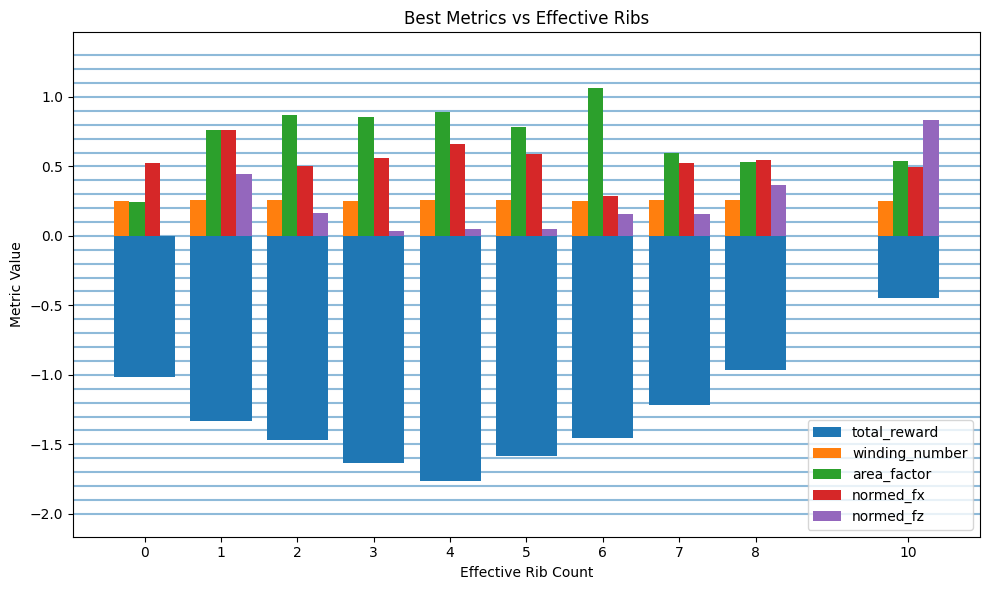

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load full history from CSV ---
csv_path = "finray_optimization_history.csv"
df = pd.read_csv(csv_path)
print(f"Loaded full history from {csv_path}, shape = {df.shape}")

# --- Post-processing: best metrics ---
best_per_eff = df.loc[df.groupby('effective_n_ribs')['reward'].idxmin()]
metrics = ['winding_number', 'area_factor', 'normed_fx', 'normed_fz']
x = best_per_eff['effective_n_ribs'].astype(int)
width = 0.2

plt.figure(figsize=(10,6))
# Background reward bars (semi-transparent, behind metrics)
reward_width = width * len(metrics)
plt.bar(x, best_per_eff['reward'], width=reward_width, label='total_reward', zorder=0)

# Individual metric bars
for i, m in enumerate(metrics):
    plt.bar(x + i*width - (len(metrics)/2 - 0.5)*width, best_per_eff[m], width, label=m, zorder=1)

# Compute grid range from negative to positive with 0.1 step
y_min, y_max = plt.ylim()
# Round to nearest 0.1
y_start = np.floor(y_min * 10) / 10
y_end = np.ceil(y_max * 10) / 10
for y in np.arange(y_start, y_end + 0.1, 0.1):
    plt.axhline(y, linestyle='-', alpha=0.5, zorder=-1)

# X-axis: only integer ticks
plt.xticks(x)

plt.xlabel("Effective Rib Count")
plt.ylabel("Metric Value")
plt.title("Best Metrics vs Effective Ribs")
plt.legend()
plt.tight_layout()
plt.savefig("finray_best_metrics.png")
print("Saved figure finray_best_metrics.png")


### D) Custom weights

In [8]:
# Constants
n_springs_front = 20
n_springs_back  = 20
n_springs_rib   = 12
L0 = 70e-3
X1 = 35e-3
beam_width = 35e-3

moving_cylinder_radius = 20e-3
moving_cylinder_displacement = 15e-3
moving_cylinder_z = 35e-3

def pick_and_resimulate(
    csv_path,
    weights,
    candidates=1,
    eff_ribs=-1
):

    """
    csv_path   : путь к finray_optimization_history.csv
    weights    : список из 5 элементов [w1,w2,w3,w4,w5]:
                 w1 * winding_number (больше - лучше)
               + w2 * area_factor (больше - лучше)
               + w3 * normed_fx (больше - лучше)
               + w4 * normed_fz (меньше - лучше)
               + w5 * (E_front/E_back) (больше - лучше)
    candidates : сколько лучших брать
    eff_ribs   : если >=0, фильтруем по effective_n_ribs == eff_ribs,
                 иначе (-1) — без фильтрации
    """

    df = pd.read_csv(csv_path)
    w1, w2, w3, w4, w5 = weights
    
    df['E_ratio'] = df.apply(
        lambda r: (r['E_front'] / r['E_back'])
                  if r['E_back'] != 0 else np.inf,
        axis=1
    )
    df['reward_new'] = (
          w1 * df['winding_number']
        + w2 * df['area_factor']
        + w3 * df['normed_fx']
        + w4 * df['normed_fz']
        + w5 * df['E_ratio']
    )

    if eff_ribs >= 0:
        df = df[df['effective_n_ribs'] == eff_ribs]

    df_sorted = df.sort_values('reward_new', ascending=True).reset_index(drop=True)
    best = df_sorted.iloc[:candidates]

    results = []
    for _, row in best.iterrows():
        phi_ribs = np.fromstring(row['phi_ribs'].strip('[]'), sep=' ')
        th_ribs  = np.fromstring(row['th_ribs'].strip('[]'), sep=' ')

        rec = {
            'requested_n_ribs':   int(row['requested_n_ribs']),
            'effective_n_ribs':   int(row['effective_n_ribs']),
            'th_front':           float(row['th_front']),
            'th_back':            float(row['th_back']),
            'xf':                 float(row['xf']),
            'zf':                 float(row['zf']),
            'phi_ribs':           phi_ribs.copy() if row['effective_n_ribs']>0 else None,
            'th_ribs':            th_ribs.copy()  if row['effective_n_ribs']>0 else None,
            'winding_number':     float(row['winding_number']),
            'area_factor':        float(row['area_factor']),
            'normed_fx':          float(row['normed_fx']),
            'normed_fz':          float(row['normed_fz']),
            'E_front':            float(row['E_front']),
            'E_back':             float(row['E_back']),
            'E_ratio':            float(row['E_ratio']),
            'reward':             float(row['reward']),
            'reward_new':         float(row['reward_new']),
        }

        rib_angles = rec['phi_ribs'].tolist() if rec['phi_ribs'] is not None else []
        rib_thicks = rec['th_ribs'].tolist()  if rec['th_ribs']  is not None else []

        sim_out = run_finray_simulation(
            rib_angles_deg               = rib_angles,
            thickness_ribs               = rib_thicks,
            n_springs_front              = n_springs_front,
            n_springs_back               = n_springs_back,
            n_springs_rib                = n_springs_rib,
            thickness_front              = rec['th_front'],
            thickness_back               = rec['th_back'],
            beam_width                   = beam_width,
            L0                           = L0,
            X1                           = X1,
            xf                           = rec['xf'],
            zf                           = rec['zf'],
            moving_cylinder_x            = moving_cylinder_radius + rec['th_front']/2,
            moving_cylinder_z            = moving_cylinder_z,
            moving_cylinder_radius       = moving_cylinder_radius,
            moving_cylinder_displacement = moving_cylinder_displacement,
            vis                          = True
        )

        results.append({
            'params': rec,
            'simulation_output': sim_out
        })

    return results

# weights in the order:
weight_winding_number = -1.0 # -
weight_area_factor    = 0.0 # -
weight_normed_fx      = 0.0 # -
weight_normed_fz      = 0.0 # +
weight_energy_ratio   = 0.0 # -

weights_custom = [weight_winding_number, weight_area_factor, weight_normed_fx, weight_normed_fz, weight_energy_ratio]
csv_file = "finray_optimization_history.csv"
top_finray = pick_and_resimulate(
             csv_path   = csv_file,
             weights    = weights_custom,
             candidates = 5,
             eff_ribs   = 6
            )

for i, entry in enumerate(top_finray, start=1):
        p = entry['params']
        print(f"\n=== Кандидат #{i} ===")
        print(f"requested_n_ribs: {p['requested_n_ribs']}")
        print(f"effective_n_ribs: {p['effective_n_ribs']}")
        print(f"th_front: {p['th_front']:.4e}")
        print(f"th_back:  {p['th_back']:.4e}")
        print(f"xf:       {p['xf']:.4e}")
        print(f"zf:       {p['zf']:.4e}")
        print(f"phi_ribs: {p['phi_ribs']}")
        print(f"th_ribs:  {p['th_ribs']}")
        print(f"winding_number: {p['winding_number']:.4f}")
        print(f"area_factor:    {p['area_factor']:.4f}")
        print(f"normed_fx:      {p['normed_fx']:.4f}")
        print(f"normed_fz:      {p['normed_fz']:.4f}")
        print(f"E_front:        {p['E_front']:.4e}")
        print(f"E_back:         {p['E_back']:.4e}")
        print(f"E_ratio:          {p['E_ratio']:.4f}")
        print(f"reward (old):   {p['reward']:.4f}")
        print(f"reward_new:     {p['reward_new']:.4f}")
        
import numpy as np
import matplotlib.pyplot as plt

# Предполагаем, что top_finray уже получен выше
indices       = np.array(list(range(1, len(top_finray)+1)))
wn_vals       = np.array([e['params']['winding_number'] for e in top_finray])
af_vals       = np.array([e['params']['area_factor']    for e in top_finray])
nfx_vals      = np.array([e['params']['normed_fx']      for e in top_finray])
nfz_vals      = np.array([e['params']['normed_fz']      for e in top_finray])
ratio_vals    = np.array([e['params']['E_ratio']        for e in top_finray])
eff_ribs_vals = np.array([e['params']['effective_n_ribs'] for e in top_finray])

# Создаём 2×3 панели
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

def plot_with_linear_trend(ax, x, y, marker, title, color=None):
    # Рисуем точки и соединяем их линией
    ax.plot(x, y, marker=marker, linestyle='-', label=title, color=color)
    # Линейная регрессия (полином 1-го порядка)
    coeffs = np.polyfit(x, y, deg=1)
    y_fit = np.polyval(coeffs, x)
    ax.plot(x, y_fit, linestyle='--', label=f'{title} trend (deg1)', color=color)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

plot_with_linear_trend(axes[0], indices, wn_vals,  'o', 'winding_number')
plot_with_linear_trend(axes[1], indices, af_vals,  's', 'area_factor')
plot_with_linear_trend(axes[2], indices, nfx_vals, '^', 'normed_fx')
plot_with_linear_trend(axes[3], indices, nfz_vals, 'v', 'normed_fz')
plot_with_linear_trend(axes[4], indices, ratio_vals, 'd', 'E_front/E_back')

# Столбчатый для числа рёбер
axes[5].bar(indices, eff_ribs_vals, color='C5')
axes[5].set_title('effective_n_ribs')
axes[5].set_xlabel('Номер кандидата')
axes[5].set_ylabel('Число рёбер')
axes[5].set_xticks(indices)
axes[5].grid(axis='y')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 